In [1]:
import os
import sys
import torch
import random
import imageio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

parent_dir = os.path.dirname(os.path.dirname(os.path.realpath("__file__")))
sys.path.insert(0, parent_dir)

from face_lib.datasets import IJBDataset, IJBCTest
from face_lib.utils import cfg
from face_lib.evaluation.feature_extractors import extract_features_head, extract_features_gan, extract_features_scale
from face_lib import models as mlib, utils
from face_lib.utils.imageprocessing import preprocess
from face_lib.evaluation.distance_uncertainty_funcs import harmonic_mean

In [2]:
device_id = 0

# uncertainty_type = "head"
uncertainty_type = "scale"

# config_path = "../configs/models/iresnet_ms1m_pfe_normalized.yaml"
config_path = "../configs/scale/02_sigm_mul_coef_selection/64.yaml"

# checkpoint_path = "/gpfs/data/gpfs0/k.fedyanin/space/models/pfe/normalized_pfe/sota.pth"
checkpoint_path = "/gpfs/data/gpfs0/k.fedyanin/space/models/scale/02_sigm_mul_selection/64/checkpoint.pth"

dataset_path = "/gpfs/gpfs0/k.fedyanin/space/IJB/aligned_data_for_fusion/big"
protocol_path = "/gpfs/gpfs0/k.fedyanin/space/IJB/IJB-C/protocols/archive"
# discriminator_path = "/gpfs/data/gpfs0/k.fedyanin/space/GAN/stylegan.pth"
discriminator_path = None
batch_size=16

In [3]:
device = torch.device("cuda:" + str(device_id))

model_args = cfg.load_config(config_path)
if uncertainty_type == "head":
    backbone = mlib.model_dict[model_args.backbone["name"]](
        **utils.pop_element(model_args.backbone, "name")
    )
    head = mlib.heads[model_args.head.name](
        **utils.pop_element(model_args.head, "name")
    )
elif uncertainty_type == "scale":
    backbone = mlib.model_dict[model_args.backbone["name"]](
        **utils.pop_element(model_args.backbone, "name")
    )
    head = mlib.scale_predictors[model_args.scale_predictor.name](
        **utils.pop_element(model_args.scale_predictor, "name")
    )
else:
    raise RuntimeError("Choose the right uncertainty_type")

checkpoint = torch.load(checkpoint_path, map_location=device)
backbone.load_state_dict(checkpoint["backbone"])

if uncertainty_type == "head":
    head.load_state_dict(checkpoint["head"])
elif uncertainty_type == "scale":
    head.load_state_dict(checkpoint["scale_predictor"])

backbone, head = backbone.eval().to(device), head.eval().to(device)

discriminator = None
if discriminator_path:
    discriminator = mlib.StyleGanDiscriminator()
    discriminator.load_state_dict(torch.load(discriminator_path)["d"])
    discriminator.eval().to(device)

In [4]:
testset = IJBDataset(dataset_path)
tester = IJBCTest(testset["abspath"].values)
tester.init_proto(protocol_path)

Number of identities :  3529
31316978 templates are initialized.


In [5]:
proc_func = lambda images: preprocess(images, [112, 112], is_training=False)

In [6]:
if uncertainty_type == "head":
    with torch.no_grad():
        mu, sigma_sq = extract_features_head(
            backbone,
            head,
            tester.image_paths,
            batch_size,
            proc_func=proc_func,
            verbose=False,
            device=device,
        )
elif uncertainty_type == "gan":
    with torch.no_grad():
        mu, sigma_sq = extract_features_gan(
            backbone,
            discriminator,
            tester.image_paths,
            batch_size,
            proc_func=proc_func,
            verbose=False,
            device=device,
        )
elif uncertainty_type == "scale":
    with torch.no_grad():
        mu, sigma_sq = extract_features_scale(
            backbone,
            head,
            tester.image_paths,
            batch_size,
            proc_func=proc_func,
            verbose=False,
            device=device,
        )

100%|██████████| 8328/8328 [24:29<00:00,  5.67it/s]


In [7]:
# uncertainties = harmonic_mean(sigma_sq)
# uncertainties = np.arange(len(tester.image_paths))
# uncertainties = sigma_sq[:, 0]

In [8]:
sigma_sq = sigma_sq.squeeze(1)

In [9]:
indices = np.argsort(sigma_sq)
new_mus = mu[indices]
uncertainties = sigma_sq[indices]
paths = tester.image_paths[indices]


In [10]:
uncertainties.shape

(133240,)

(array([  450.,  1582.,  2215.,  2610.,  2786.,  2677.,  2777.,  2657.,
         2707.,  2853.,  3024.,  3273.,  3685.,  4082.,  4933.,  6259.,
         8326., 12192., 20604., 43548.]),
 array([ 0.90091586,  4.055724  ,  7.210532  , 10.36534   , 13.520148  ,
        16.674957  , 19.829765  , 22.984573  , 26.139381  , 29.29419   ,
        32.448997  , 35.603806  , 38.758614  , 41.91342   , 45.06823   ,
        48.223038  , 51.377846  , 54.532654  , 57.68746   , 60.84227   ,
        63.997078  ], dtype=float32),
 <BarContainer object of 20 artists>)

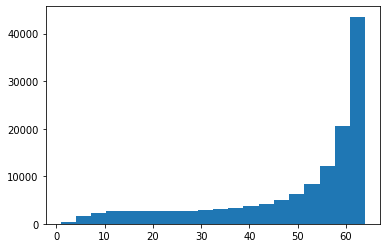

In [11]:
plt.hist(uncertainties, bins=20)

In [12]:
def get_mean_of_images(pic_paths):
#     sum_pictures = np.empty((3, 120, 120), dtype=float)
    sum_pictures = 0.
    
    for path in pic_paths:
        pic = imageio.imread(path)
        sum_pictures += pic
        
    return sum_pictures / len(pic_paths)


def get_borders(uncertainties, n_groups=8, split_type="equal"):
    indices = []
    if split_type == "equal":
        for quantile_idx in range(n_groups):
            left_idx = int(quantile_idx / n_groups * len(uncertainties))
            right_idx = int((quantile_idx + 1) / n_groups * len(uncertainties))
            indices.append((left_idx, right_idx))
    elif split_type == "ranges":
        step = 64. / n_groups
        for quantile_idx in range(n_groups):
            left_idx = np.searchsorted(uncertainties, quantile_idx * step, side="right")
            right_idx = np.searchsorted(uncertainties, (quantile_idx + 1) * step, side="left")
            indices.append((left_idx, right_idx))
    else:
        raise RuntimeError()
    return indices


def get_mean_of_faces(sorted_paths, uncertainties, n_groups=10, split_type="equal"):
    quantile_paths = []

    indices = get_borders(uncertainties, n_groups=n_groups, split_type=split_type)
    for left_idx, right_idx in indices:

        quantile_paths.append(sorted_paths[left_idx:right_idx])

    mean_faces = [get_mean_of_images(paths) for paths in quantile_paths]
    return mean_faces
   
def get_keywords(sorted_paths, uncertainties, n_groups=8, split_type="equal"):
    data = [{} for _ in range(n_groups)]
    
    indices = get_borders(uncertainties, n_groups=n_groups, split_type=split_type)
    
    for (left_idx, right_idx), d in zip(indices, data):
#     for quantile_idx, d in zip(range(n_groups), data):
#         left_idx = int(quantile_idx / n_groups * len(sorted_paths))
#         right_idx = int((quantile_idx + 1) / n_groups * len(sorted_paths))
        
        d["n_pics"] = len(sorted_paths[left_idx:right_idx])
        d["mean_unc"] = uncertainties[left_idx:right_idx].mean()
        d["left_unc"] = round(uncertainties[left_idx], 1)
        d["right_unc"] = round(uncertainties[right_idx - 1], 1)
    return data
        

In [13]:
split_type = "ranges"
n_groups = 8

means = get_mean_of_faces(paths, uncertainties, n_groups=n_groups, split_type=split_type)
data = get_keywords(paths, uncertainties, n_groups=n_groups, split_type=split_type)

In [14]:
data

[{'n_pics': 2552, 'mean_unc': 5.711194, 'left_unc': 0.9, 'right_unc': 8.0},
 {'n_pics': 6521, 'mean_unc': 12.1994705, 'left_unc': 8.0, 'right_unc': 16.0},
 {'n_pics': 6893, 'mean_unc': 20.028734, 'left_unc': 16.0, 'right_unc': 24.0},
 {'n_pics': 6930, 'mean_unc': 28.061806, 'left_unc': 24.0, 'right_unc': 32.0},
 {'n_pics': 8166, 'mean_unc': 36.171635, 'left_unc': 32.0, 'right_unc': 40.0},
 {'n_pics': 10889, 'mean_unc': 44.272667, 'left_unc': 40.0, 'right_unc': 48.0},
 {'n_pics': 19992, 'mean_unc': 52.522778, 'left_unc': 48.0, 'right_unc': 56.0},
 {'n_pics': 71297, 'mean_unc': 61.11643, 'left_unc': 56.0, 'right_unc': 64.0}]

In [30]:
def pretty_matplotlib_config(fontsize=15):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    matplotlib.rcParams['text.usetex'] = True
    matplotlib.rcParams.update({'font.size': fontsize})

def plot_means(means, pics_data, save_path=None):
#     means = get_mean_of_faces(sorted_paths, n_groups=len(means))
    pretty_matplotlib_config(30)

    size = - 0.1
    grid_spec_kw = {
#         "hspace": size,
        "wspace": size,
    }
    
    fig, axes = plt.subplots(ncols=len(means), figsize=(5 * len(means), 5), gridspec_kw=grid_spec_kw)
    
    for img, ax, d in zip(means, axes, pics_data):
        ax.imshow(img / 256)
#         ax.get_xaxis().set_visible(False)
#         ax.get_yaxis().set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        
        print(d['left_unc'], d['right_unc'])
        caption = f"\# of images : {d['n_pics']}\nRange : [{d['left_unc']:.1f} {d['right_unc']:.1f}]"
        print(caption)
        ax.set_xlabel(caption)

#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#     fig.tight_layout(rect=[0.05, 0.03, 0.95, 1.0])
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

0.9 8.0
\# of images : 2552
Range : [0.9 8.0]
8.0 16.0
\# of images : 6521
Range : [8.0 16.0]
16.0 24.0
\# of images : 6893
Range : [16.0 24.0]
24.0 32.0
\# of images : 6930
Range : [24.0 32.0]
32.0 40.0
\# of images : 8166
Range : [32.0 40.0]
40.0 48.0
\# of images : 10889
Range : [40.0 48.0]
48.0 56.0
\# of images : 19992
Range : [48.0 56.0]
56.0 64.0
\# of images : 71297
Range : [56.0 64.0]


<ipython-input-30-7c6bd1a35cfe>:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


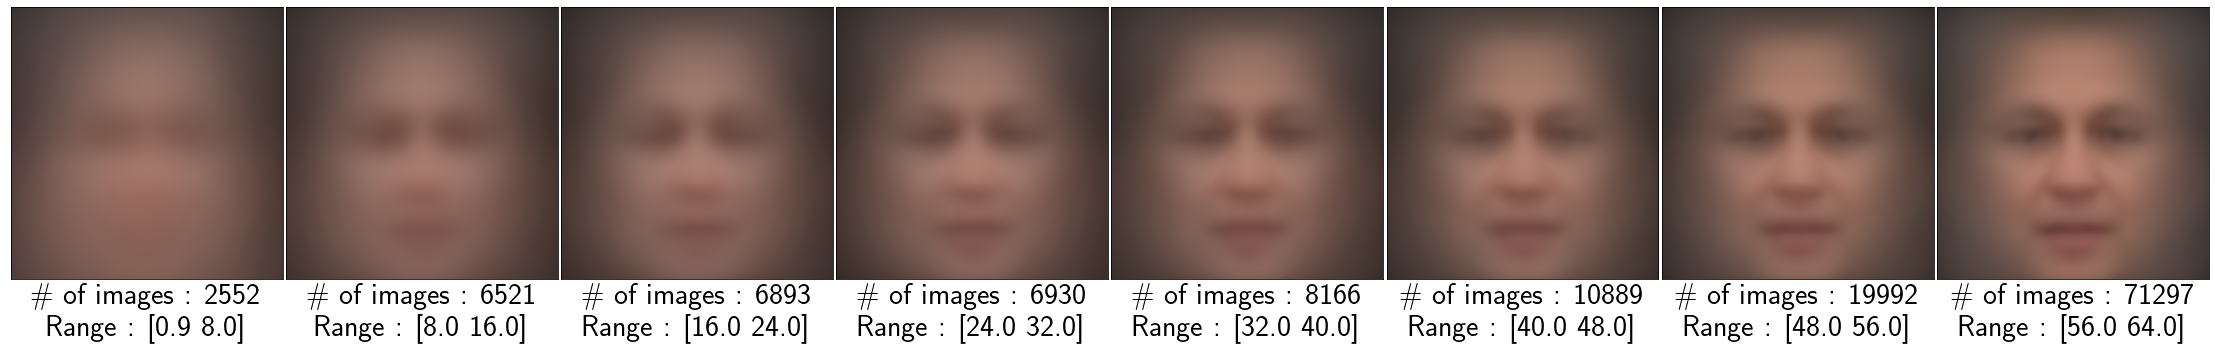

In [31]:
plot_means(
    means,
    pics_data=data,
    save_path="/beegfs/home/r.kail/faces/figures/30_face_sums/equal_ranges.pdf")

In [17]:
# def show_picture(path, ax):
# #     print(f"Path : {path}")
#     pic = imageio.imread(path)
#     ax.imshow(pic)
    
# def show_pics_quantiles(sorted_paths, n_groups=10, n_pics=5, save_path=None):
#     fig, axes = plt.subplots(n_groups, n_pics, figsize=(30, 30))
    
#     for quantile_idx in range(n_groups):
#         left_idx = int(quantile_idx / n_groups * len(sorted_paths))
#         right_idx = int((quantile_idx + 1) / n_groups * len(sorted_paths))
        
#         picture_paths = random.sample(list(sorted_paths[left_idx: right_idx]), k=n_pics)
# #         print(picture_paths, left_idx, right_idx)
#         for pic_path, ax in zip(picture_paths, axes[quantile_idx]):
# #             print (pic_path.shape, pic_path[0])
#             show_picture(pic_path, ax)
            
#     names = [str(quantile_idx / n_groups * 100) + "-" + str((quantile_idx + 1) / n_groups * 100) + "%" for quantile_idx in range(n_groups)]
#     pad = 20
#     for ax, row in zip(axes[:, 0], names):
#         ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                     xycoords=ax.yaxis.label, textcoords='offset points',
#                     size='large', ha='right', va='center')
        
#     if save_path:
#         plt.savefig(save_path, dpi=400)
#     plt.show()

In [18]:
# for idx in range(5):
#     show_pics_quantiles(
#         paths, n_groups=10, n_pics=10,
#         save_path=f"/beegfs/home/r.kail/faces/figures/14_sorted_faces/pfe/{idx}.pdf")

In [19]:
# show_pics_quantiles(
#         paths, n_groups=10, n_pics=10,
#         save_path=f"/beegfs/home/r.kail/faces/figures/14_sorted_faces/pfe/{idx}.pdf")